In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [23]:
def load_data(path):
    df = pd.read_csv(path, skiprows=1)
    df.columns = df.columns.str.strip()

    # Rename first column to Client Type
    df = df.rename(columns={df.columns[0]: "Client Type"})

    # Remove TOTAL row
    df = df[df["Client Type"] != "TOTAL"]

    # Convert numeric columns
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    return df


In [24]:
def compute_net_positions(df):
    df["Net_Futures"] = (
        df["Future Index Long"] + df["Future Stock Long"]
        - df["Future Index Short"] - df["Future Stock Short"]
    )

    df["Net_Call_OI"] = (
        df["Option Index Call Long"] + df["Option Stock Call Long"]
        - df["Option Index Call Short"] - df["Option Stock Call Short"]
    )

    df["Net_Put_OI"] = (
        df["Option Index Put Long"] + df["Option Stock Put Long"]
        - df["Option Index Put Short"] - df["Option Stock Put Short"]
    )

    return df


In [25]:
def calculate_participant_sentiment(df):
    total_futures_oi = np.sum(np.abs(df["Net_Futures"]))

    if total_futures_oi == 0:
        raise ValueError("Total Futures OI is zero")

    df["Futures_Bias"] = df["Net_Futures"] / total_futures_oi

    df["Option_Bias"] = df["Net_Put_OI"] - df["Net_Call_OI"]

    df["Normalized_Option_Bias"] = np.where(
        (df["Net_Put_OI"] + df["Net_Call_OI"]) == 0,
        0,
        df["Option_Bias"] / (df["Net_Put_OI"] + df["Net_Call_OI"])
    )

    df["Participant_Score"] = (
        0.6 * df["Futures_Bias"]
        + 0.4 * df["Normalized_Option_Bias"]
    )

    df["Sentiment"] = np.where(
        df["Participant_Score"] > 0.20, "Bullish",
        np.where(df["Participant_Score"] < -0.20, "Bearish", "Neutral")
    )

    return df


In [26]:
def plot_participant_sentiment(df):
    if df.empty:
        print("⚠️ No data to plot")
        return

    plt.figure(figsize=(8, 4))
    plt.axvline(0)

    plt.barh(df["Client Type"], df["Participant_Score"])
    plt.xlim(-1, 1)

    plt.xlabel("Participant Score (−1 to +1)")
    plt.title("NSE F&O Market Sentiment (Participant-wise)")
    plt.grid(axis="x", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


In [34]:
def sentiment_color(score):
    if score > BULLISH_LIMIT:
        return "green"
    elif score < BEARISH_LIMIT:
        return "red"
    else:
        return "gray"


In [35]:
def plot_participant_sentiment(df):
    if df.empty:
        print("⚠️ No data to plot")
        return

    scores = df["Participant_Score"].astype(float)
    participants = df["Client Type"].astype(str)
    colors = [sentiment_color(s) for s in scores]

    plt.figure(figsize=(9, 4))

    # 🔹 SCALE BANDS
    plt.axvspan(-1, BEARISH_LIMIT, color="red", alpha=0.08, label="Bearish (< -0.20)")
    plt.axvspan(BEARISH_LIMIT, BULLISH_LIMIT, color="gray", alpha=0.08, label="Neutral (-0.20 to +0.20)")
    plt.axvspan(BULLISH_LIMIT, 1, color="green", alpha=0.08, label="Bullish (> +0.20)")

    # Reference lines
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.axvline(BEARISH_LIMIT, linestyle="--", linewidth=0.8)
    plt.axvline(BULLISH_LIMIT, linestyle="--", linewidth=0.8)

    # Bars
    plt.barh(participants, scores, color=colors)

    plt.xlim(-1, 1)
    plt.xlabel("Participant Score (−1 to +1)")
    plt.title("NSE F&O Participant-wise Market Sentiment")

    plt.legend(loc="lower right", fontsize=9)
    plt.grid(axis="x", linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()


In [30]:
def calculate_overall_market_sentiment(df):
    market_score = df["Participant_Score"].mean()

    if market_score > 0.20:
        sentiment = "Bullish"
    elif market_score < -0.20:
        sentiment = "Bearish"
    else:
        sentiment = "Neutral"

    return market_score, sentiment


In [36]:
def plot_market_sentiment_gauge(market_score, sentiment):
    plt.figure(figsize=(7, 2))

    # Background scale
    plt.barh(["Market"], [1], left=-1, color="lightgray")

    # Sentiment zones
    plt.barh(["Market"], [abs(BEARISH_LIMIT + 1)], left=-1, color="#fca5a5", alpha=0.6)
    plt.barh(["Market"], [BULLISH_LIMIT - BEARISH_LIMIT], left=BEARISH_LIMIT, color="#d1d5db", alpha=0.6)
    plt.barh(["Market"], [1 - BULLISH_LIMIT], left=BULLISH_LIMIT, color="#86efac", alpha=0.6)

    # Actual market score
    plt.barh(["Market"], [market_score], color="black")

    # Scale markers
    plt.axvline(BEARISH_LIMIT, linestyle="--", linewidth=1)
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.axvline(BULLISH_LIMIT, linestyle="--", linewidth=1)

    plt.xlim(-1, 1)
    plt.yticks([])

    plt.title(
        f"Overall Market Sentiment: {sentiment} ({market_score:.2f})\n"
        f"Bearish < {BEARISH_LIMIT} | Neutral {BEARISH_LIMIT} to {BULLISH_LIMIT} | Bullish > {BULLISH_LIMIT}"
    )

    plt.tight_layout()
    plt.show()


  Client Type  Participant_Score Sentiment
0      Client          -6.491359   Bearish
1         DII          -0.834520   Bearish
2         FII           0.557294   Bullish
3         Pro          -5.908579   Bearish


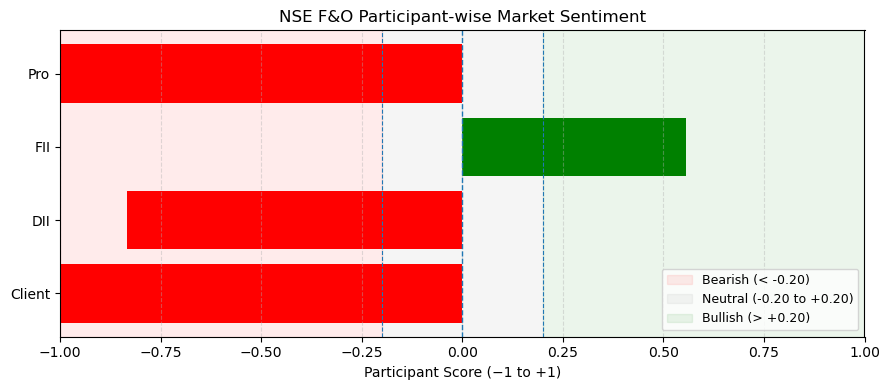


Overall Market Sentiment: Bearish (-3.17)


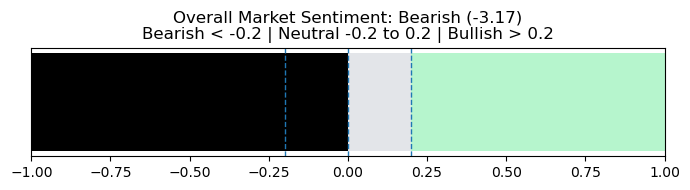

In [40]:
if __name__ == "__main__":
    df = load_data("csv_files/fao_participant_oi_07012026.csv")
    df = compute_net_positions(df)
    df = calculate_participant_sentiment(df)
    BEARISH_LIMIT = -0.20
    BULLISH_LIMIT = 0.20
    print(df[["Client Type", "Participant_Score", "Sentiment"]])

    # Participant-wise sentiment chart
    plot_participant_sentiment(df)

    # Overall market sentiment
    market_score, market_sentiment = calculate_overall_market_sentiment(df)

    print(f"\nOverall Market Sentiment: {market_sentiment} ({market_score:.2f})")

    # Market sentiment gauge
    plot_market_sentiment_gauge(market_score, market_sentiment)
